<a href="https://colab.research.google.com/github/bivek2211/NLP/blob/master/RNN%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN for short-term predicton


This model will predict next value in a short sequence based on historical data. This can be used for example to predict demand based on couple of weeks of sales data

In [7]:
import math
import numpy as np
import tensorflow as tf
from enum import IntEnum
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import transforms as plttrans

print("tensorflow version : " + tf.__version__)

tensorflow version : 1.13.1


In [0]:
class Waveforms(IntEnum):
    SINE1 = 0
    SINE2 = 1
    SINE3 = 2
    SINE4 = 3

    
def create_time_series(waveform, datalen):
    # Generates a sequence of length datalen
    # There are three available waveforms in the Waveforms enum
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55), (0.4, 0.25)]
    freq1, freq2 = frequencies[waveform]
    noise = [np.random.random()*0.2 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

In [0]:
def picture_this_1(data, datalen):
    plt.subplot(211)
    plt.plot(data[datalen-512:datalen+512])
    plt.axvspan(0, 512, color='black', alpha=0.06)
    plt.axvspan(512, 1024, color='grey', alpha=0.04)
    plt.subplot(212)
    plt.plot(data[3*datalen-512:3*datalen+512])
    plt.axvspan(0, 512, color='grey', alpha=0.04)
    plt.axvspan(512, 1024, color='black', alpha=0.06)
    plt.show()

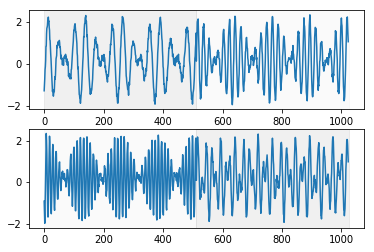

In [18]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([create_time_series(waveform, DATA_SEQ_LEN) for 
                       waveform in Waveforms])

picture_this_1(data, DATA_SEQ_LEN)

In [0]:
## hyperparameters


NB_EPOCHS = 10      # number of times the data is repeated during training
RNN_CELLSIZE = 32   # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

In [0]:
def picture_this_2(data, batchsize, seqlen):
    samples = np.reshape(data, [-1, batchsize, seqlen])
    rndsample = samples[np.random.choice(samples.shape[0], 8, replace=False)]
    print("Tensor shape of a batch of training sequences: " + str(rndsample[0].shape))
    print("Random excerpt:")
    subplot = 241
    for i in range(8):
        plt.subplot(subplot)
        plt.plot(rndsample[i, 0]) # first sequence in random batch
        subplot += 1
    plt.show()

**Visualize training sequences**

This is what neural network will see during training.

Tensor shape of a batch of training sequences: (32, 16)
Random excerpt:


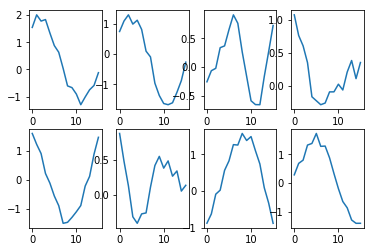

In [24]:
picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

**Defining models**

When executed, these functions instantiates the Tensorflow graph for our model.

In [0]:
# tree simplistic predictive models
def simplistic_models(X):
    # "random" model
    Yrnd = tf.random_uniform([tf.shape(X)[0]], -2.0, 2.0) # tf.shape(X)[0] is the batch size
    # "same as last" model
    Ysal = X[:,-1]
    # "trend from last two" model
    Ytfl = X[:,-1] + (X[:,-1] - X[:,-2])
    return Yrnd, Ysal, Ytfl

In [0]:
# linear model (RMSE: 0.36, with shuffling: 0.17)
def linear_model(X):
    Yout = tf.layers.dense(X, 1) # output shape [BATCHSIZE, 1]
    return Yout

In [0]:
# 2-layer dense model (RMSE: 0.38, with shuffling: 0.15-0.18)
def DNN_model(X):
    Y = tf.layers.dense(X, SEQLEN//2, activation=tf.nn.relu)
    Yout = tf.layers.dense(Y, 1, activation=None) # output shape [BATCHSIZE, 1]
    return Yout

In [0]:
# convolutional (RMSE: 0.31, with shuffling: 0.16)
def CNN_model(X):
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    Y = tf.layers.conv1d(X, filters=8, kernel_size=4, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=16, kernel_size=3, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=1, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=3, activation=tf.nn.relu, padding="same")  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    Yout = tf.layers.conv1d(Y, filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid") # output shape [BATCHSIZE, 1, 1]
    Yout = tf.squeeze(Yout, axis=-1) # output shape [BATCHSIZE, 1]
    return Yout

In [0]:
# RNN model (RMSE: 0.38, with shuffling 0.14, the same with loss on last 8)
def RNN_model(X, n=1):
    # 2-layer RNN
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    cell1 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell2 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2], state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # Yn [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    
    # regression head
    batchsize = tf.shape(X)[0]
    Yn = tf.reshape(Yn, [batchsize*SEQLEN, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, SEQLEN, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    
    # In this RNN model, you can compute the loss on the last predicted item or the lats n predicted items
    # Last n is slightly better.
    Yout = Yr[:,-n:SEQLEN,:] # last item(s) in sequence: output shape [BATCHSIZE, n, 1]
    Yout = tf.squeeze(Yout, axis=-1)
    return Yout

In [0]:
def RNN_model_N(X): return RNN_model(X, n=SEQLEN//2)

In [0]:
def model_fn(features, labels, model):
    X = features # shape [BATCHSIZE, SEQLEN]
    
    Y = model(X)

    last_label = labels[:, -1] # last item in sequence: the target value to predict
    last_labels = labels[:, -tf.shape(Y)[1]:SEQLEN] # last p items in sequence (as many as in Y), useful for RNN_model(X, n>1)

    loss = tf.losses.mean_squared_error(Y, last_labels) # loss computed on last label(s)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    Yrnd, Ysal, Ytfl = simplistic_models(X)
    eval_metrics = {"RMSE": tf.sqrt(loss),
                    # compare agains three simplistic predictive models: can you beat them ?
                    "RMSErnd": tf.sqrt(tf.losses.mean_squared_error(Yrnd, last_label)),
                    "RMSEsal": tf.sqrt(tf.losses.mean_squared_error(Ysal, last_label)),
                    "RMSEtfl": tf.sqrt(tf.losses.mean_squared_error(Ytfl, last_label))}
    
    Yout = Y[:,-1]
    return Yout, loss, eval_metrics, train_op

**preparing training dataset**


In [0]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)
# slice data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# also make an evaluation dataset by randomly subsampling our fake data
EVAL_SEQUENCES = DATA_SEQ_LEN*4//SEQLEN//4
joined_data = np.stack([traindata, labeldata], axis=1) # new shape is [N_sequences, 2(train/eval), SEQLEN]
joined_evaldata = joined_data[np.random.choice(joined_data.shape[0], EVAL_SEQUENCES, replace=False)]
evaldata = joined_evaldata[:,0,:]
evallabels = joined_evaldata[:,1,:]

def datasets(nb_epochs):
    # Dataset API for batching, shuffling, repeating
    dataset = tf.data.Dataset.from_tensor_slices((traindata, labeldata))
    dataset = dataset.repeat(NB_EPOCHS)
    dataset = dataset.shuffle(DATA_SEQ_LEN*4//SEQLEN) # important ! Number of sequences in shuffle buffer: all of them
    dataset = dataset.batch(BATCHSIZE)
    
    # Dataset API for batching
    evaldataset = tf.data.Dataset.from_tensor_slices((evaldata, evallabels))
    evaldataset = evaldataset.repeat()
    evaldataset = evaldataset.batch(EVAL_SEQUENCES) # just one batch with everything

    # Some boilerplate code...
    
    # this creates a Tensorflow iterator of the correct type and shape
    # compatible with both our training and eval datasets
    tf_iter = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
    # it can be initialized to iterate through the training dataset
    dataset_init_op = tf_iter.make_initializer(dataset)
    # or it can be initialized to iterate through the eval dataset
    evaldataset_init_op = tf_iter.make_initializer(evaldataset)
    # Returns the tensorflow nodes needed by our model_fn.
    features, labels = tf_iter.get_next()
    # When these nodes will be executed (sess.run) in the training or eval loop,
    # they will output the next batch of data.

    # Note: when you do not need to swap the dataset (like here between train/eval) just use
    # features, labels = dataset.make_one_shot_iterator().get_next()
    # TODO: easier with tf.estimator.inputs.numpy_input_fn ???
    
    return features, labels, dataset_init_op, evaldataset_init_op

**instantiate the model**

In [33]:
tf.reset_default_graph() # restart model graph from scratch
# instantiate the dataset
features, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
# instantiate the model
Yout, loss, eval_metrics, train_op = model_fn(features, labels, RNN_model_N)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


**Initialize Tensorflow session**

This resets all neuron weights and biases to initial random values

In [0]:
# variable initialization

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

**The training loop**

You can re-execute this cell to continue training

In [36]:
count = 0
losses = []
indices = []
sess.run(dataset_init_op)
while True:
    try: loss_, _ = sess.run([loss, train_op])
    except tf.errors.OutOfRangeError: break
    # print progress
    if count%300 == 0:
        epoch = count // (DATA_SEQ_LEN*4//BATCHSIZE//SEQLEN)
        print("epoch " + str(epoch) + ", batch " + str(count) + ", loss=" + str(loss_))
    if count%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(count)
    count += 1
    
# final evaluation
sess.run(evaldataset_init_op)
eval_metrics_, Yout_ = sess.run([eval_metrics, Yout])
print("Final accuracy on eval dataset:")
print(str(eval_metrics_))

epoch 0, batch 0, loss=0.91794467
epoch 0, batch 300, loss=0.036288075
epoch 0, batch 600, loss=0.03476104
epoch 0, batch 900, loss=0.033243667
epoch 1, batch 1200, loss=0.035971537
epoch 1, batch 1500, loss=0.03012625
epoch 1, batch 1800, loss=0.030521065
epoch 2, batch 2100, loss=0.030405274
epoch 2, batch 2400, loss=0.029649096
epoch 2, batch 2700, loss=0.02925384
epoch 2, batch 3000, loss=0.02680051
epoch 3, batch 3300, loss=0.03053023
epoch 3, batch 3600, loss=0.027338063
epoch 3, batch 3900, loss=0.02556573
epoch 4, batch 4200, loss=0.024942944
epoch 4, batch 4500, loss=0.024716135
epoch 4, batch 4800, loss=0.020362567
epoch 4, batch 5100, loss=0.024465362
epoch 5, batch 5400, loss=0.024645085
epoch 5, batch 5700, loss=0.026640784
epoch 5, batch 6000, loss=0.023978896
epoch 6, batch 6300, loss=0.020647883
epoch 6, batch 6600, loss=0.022467446
epoch 6, batch 6900, loss=0.022526866
epoch 7, batch 7200, loss=0.025058573
epoch 7, batch 7500, loss=0.024380233
epoch 7, batch 7800, loss

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


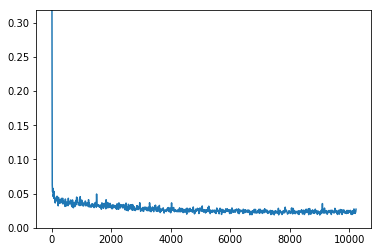

In [37]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value(s) for scaling
plt.plot(indices, losses)
plt.show()

In [0]:
def picture_this_3(Yout_, evaldata, evallabels, seqlen):
    subplot = 241
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i in range(8):
        plt.subplot(subplot)
        k = int(np.random.rand() * evaldata.shape[0])
        l0, = plt.plot(evaldata[k, 1:], label="data")
        plt.plot([seqlen-2, seqlen-1], evallabels[k, -2:])
        l1, = plt.plot([seqlen-1], [Yout_[k]], "o", color="red", label='Predicted')
        l2, = plt.plot([seqlen-1], [evallabels[k][-1]], "o", color=colors[1], label='Ground Truth')
        if i==0:
            plt.legend(handles=[l0, l1, l2])
        subplot += 1
    plt.show()

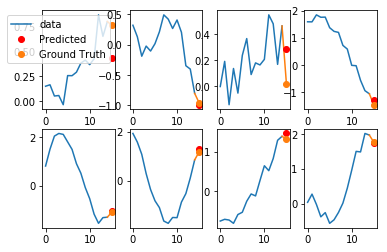

In [40]:
# execute multiple times to see different sample sequences
picture_this_3(Yout_, evaldata, evallabels, SEQLEN)

**Benchmark**

Benchmark all the algorithms. This takes a while (approx. 10 min).

In [41]:
NB_EPOCHS = 10
sess.close()
models = [linear_model, DNN_model, CNN_model, RNN_model, RNN_model_N]
for model in models:
    # reset tensorflow graph: start from scratch
    tf.reset_default_graph()
    # instantiate the dataset
    features, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
    # instantiate model
    Yout, loss, eval_metrics, train_op = model_fn(features, labels, model)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        # training loop
        sess.run([init, dataset_init_op])
        while True:
            try: sess.run(train_op)
            except tf.errors.OutOfRangeError: break
        # evaluation
        sess.run(evaldataset_init_op)
        eval_metrics_ = sess.run(eval_metrics)
        print(str(model))
        print(str(eval_metrics_))


<function linear_model at 0x7f5576f96510>
{'RMSE': 0.21723752, 'RMSErnd': 1.5476155, 'RMSEsal': 0.4158021, 'RMSEtfl': 0.3436808}
<function DNN_model at 0x7f5576f96598>
{'RMSE': 0.21341617, 'RMSErnd': 1.5462297, 'RMSEsal': 0.4158021, 'RMSEtfl': 0.3436808}
Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
Use keras.layers.max_pooling1d instead.
<function CNN_model at 0x7f5579dd3620>
{'RMSE': 0.19436714, 'RMSErnd': 1.5299308, 'RMSEsal': 0.4158021, 'RMSEtfl': 0.3436808}
<function RNN_model at 0x7f5576f966a8>
{'RMSE': 0.16228117, 'RMSErnd': 1.5402048, 'RMSEsal': 0.4158021, 'RMSEtfl': 0.3436808}
<function RNN_model_N at 0x7f5576f96a60>
{'RMSE': 0.152392, 'RMSErnd': 1.557653, 'RMSEsal': 0.4158021, 'RMSEtfl': 0.3436808}
